# Tamaño de muestra con estratos
    - La pregunta principal es cómo repartir n entre los L estratos. Existen tres factores principales por considerar para responder esta pregunta.
        - La varianza dentro de cada estrato
        - La proporción N_h/N
        - El costo de obtener información en cada estrato C_h
        
    - Primero se calcula n, que también depende de dichos factores, para después hacer la proporción n_h para cada estrato
    
    - Se define una función de costo:
        C = C_0 + sum[for h in L](C_h * n_h)
            donde:
            C: Costo total
            C_0: Costo fijo
            C_h: Costo de obtener información de una unidad en el estrato h

### Conclusiones
    - Realizar una prueba piloto es esencial para distribuir correctamente el tamañó dentro de los estratos.

### 1] Definir una población
    - Notación:
        L: Número de estratos
        N: Tamaño poblacional
        N_h: Unidades poblacionales dentro de cada estrato
        Y[h,i]: Observación en el estrato h de la unidad i
    
    - Los parámetros como la media, varianza y total se calculan por separado para cada estrato como si fueran una población por separado. Para los cálculos poblacionales, los elementos son considerados con el mismo peso de importancia.  

Parámetros poblacionales

La media de calificación es:  6.89
El total de dinero es:  730365
La proporción hombres/mujeres es:  0.56


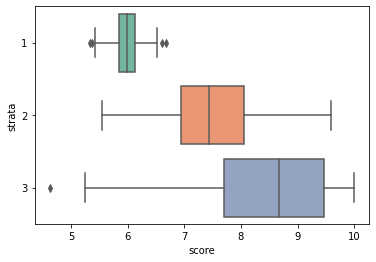

In [308]:
import pandas as pd
import numpy as np
import seaborn as sns

# Define the strata
# ... 600 is the total population, while the other elements in the list
# ... represent the units within each strata
# ... sample size is initially defined only for m.a.s.
L = 3
N = [600, 300, 200, 100]
n = [75, 0, 0, 0]
cost = [0, 20, 15, 10]
confidence = 0.95

# Create DF outlining the strata for each unit
strata = np.repeat([1,2,3], N[1:])
df_population = pd.DataFrame(strata, columns=["strata"])

# Define score variable
score =                  np.random.normal(loc=6,   scale=0.25, size=N[1])
score = np.append(score, np.random.normal(loc=7.5, scale=0.75, size=N[2]))
score = np.append(score, np.random.normal(loc=8.5, scale=1.50, size=N[3]))
score = np.where(score>10, 10, score)
score = np.where(score< 0,  0, score)
df_population["score"] = score

# Define money variable
money =                  np.random.normal(loc=1500, scale=300, size=N[1])
money = np.append(money, np.random.normal(loc=1000, scale=200, size=N[2]))
money = np.append(money, np.random.normal(loc= 800, scale=100, size=N[3]))
money = np.where(money<0, 0, money)
df_population["money"] = money

# Define sex variable
sex =                (0.50 < np.random.uniform(size=N[1]))
sex = np.append(sex, (0.25 < np.random.uniform(size=N[2])))
sex = np.append(sex, (0.75 < np.random.uniform(size=N[3])))
df_population["sex"] = sex.astype(int)

# Graph score data
sns.set_palette("Set2")
sns.boxplot(data=df_population, x="score", y=df_population["strata"].astype(str))

# Output
print("="*100)
print("Parámetros poblacionales\n")
print("La media de calificación es: ", round(df_population["score"].mean(axis=0),2))
print("El total de dinero es: ", int(df_population["money"].sum(axis=0)))
print("La proporción hombres/mujeres es: ", round(df_population["sex"].mean(axis=0),2))
print("="*100)

### 2] Distribuir n_h dado una n fija
    - Existen tres formas de distribuir n a través de los L estratos. Cada una implica considerar diferentes factores ente el costo (C), la varianza (S) y el tamaño poblacional (N)
    
    - Se busca minimizar V(mean) de la variable objetivo
    
    - Distribución óptima (C, S, N). Los tamañños muestrales n_h se calculan como:
        n_h = n * N_h*S_h*C_h^(-0.5) / sum[for k in L](N_k*S_k*C_k^(-0.5))
            donde:
            N_h: Tamaño poblacional en el estrato h
            S_h: Desviación estándar de la variable objetivo en el estrato h
            C_h: Costo de obtener información en el estrato h
            
    - Distribución de Neyman (S, N). Considera que el costo es constante para cada estrato.
        n_h = n * N_h*S_h / sum[for k in L](N_k*S_k)
        
    - Distribución proporcional (N). Solo considera el tamaño del estrato dentro de la población
        n_h = n * N_h / sum[for k in L](N_k)
    

In [310]:
# Analysis is done to estimate mean of score
print("="*100)

# Run a pilot sample with 20 elements within each strata
std = [0, 0, 0, 0]
strata = df_population["strata"]
for h in range(1,L+1):
    std[h] = df_population["score"][strata==h].sample(n=10).std(0, ddof=1)


    
# Optimal distribution of sample size
for h in range(1,L+1):
    n[h] = n[0] * N[h]*std[h]*cost[h]**-0.5 / sum(
                  N[k]*std[k]*cost[k]**-0.5 for k in range(1,L+1))
n = np.ceil(n).astype(int)

# Select sample
df_sample = pd.DataFrame()
strata = df_population["strata"]
for h in range(1, +1):
    df_temporal = df_population[strata==h].sample(n=n[h])
    df_sample = pd.concat([df_sample, df_temporal])
# Calculate std of mean estimator
strata = df_sample["strata"]
mean_var = sum( (N[h]/N[0])**2 * (1-n[h]/N[h]) * 1/n[h] *   
               df_sample["score"][strata==h].var(0, ddof=1) for h in range(1,L+1))
mean_std = mean_var**0.5
print("Distribución óptima:\n",n[1:]," | ","std(mean):",round(mean_std,2))




# Neyman distribution
for h in range(1,L+1):
    n[h] = n[0] * N[h]*std[h] / sum(
                  N[k]*std[k] for k in range(1,L+1))
n = np.ceil(n).astype(int)

# Select sample
df_sample = pd.DataFrame()
strata = df_population["strata"]
for h in range(1,L+1):
    df_temporal = df_population[strata==h].sample(n=n[h])
    df_sample = pd.concat([df_sample, df_temporal])
# Calculate std of mean estimator
strata = df_sample["strata"]
mean_var = sum( (N[h]/N[0])**2 * (1-n[h]/N[h]) * 1/n[h] *   
               df_sample["score"][strata==h].var(0, ddof=1) for h in range(1,L+1))
mean_std = mean_var**0.5
print("\nDistribución de Neyman:\n",n[1:]," | ","std(mean):",round(mean_std,2))



# Proportional distribution
for h in range(1,L+1):
    n[h] = n[0] * N[h] / sum(
                  N[k] for k in range(1,L+1))
n = np.ceil(n).astype(int)

# Select sample
df_sample = pd.DataFrame()
strata = df_population["strata"]
for h in range(1,L+1):
    df_temporal = df_population[strata==h].sample(n=n[h])
    df_sample = pd.concat([df_sample, df_temporal])
# Calculate std of mean estimator
strata = df_sample["strata"]
mean_var = sum( (N[h]/N[0])**2 * (1-n[h]/N[h]) * 1/n[h] *   
               df_sample["score"][strata==h].var(0, ddof=1) for h in range(1,L+1))
mean_std = mean_var**0.5
print("\nDistribución proporcional:\n",n[1:]," | ","std(mean):",round(mean_std,2))



# End block
print("="*100)

Distribución óptima:
 [ 7 29 37]  |  std(mean): 0.07

Distribución de Neyman:
 [ 9 32 33]  |  std(mean): 0.07

Distribución proporcional:
 [37 25 12]  |  std(mean): 0.08


### Definir tamaño de muestra total
    - De manera general, se puede optimizar el costo del muestreo cuando se tiene un presupuesto fijo, con lo que se obtiene:
        n = (c-c_0) * sum[h in L](N_h*s_h / c_h^0.5) / sum[h in L](N_h*s_h * c_h^0.5)
            donde:
            c: Presupuesto total para la encuensta
            c_0: Costos fijos
            c_h: Costo de obtener información en el estrato h
            N_h: Tamaño poblacional del estrato h
            s_h: Estimador de la desviación estándar en el estrato h
            
    - Media. Para establecer una precisión mientras que se optimiza (C,S,N) se utiliza:
        n = sum[for h in L](N_h*s_h*c_h * sum[for k in L](N_k*s_k/c_k))
            / ((N*delta/z)^2 + sum[for h in L](N_h*s_h))
            donde:
            delta: Precisión deseada en el estimador
            z: Inversa de la normal estándar para el nivel de confianza desado
            
    - Total. Para establecer una precisión mientras que se optimiza (C,S,N) se utiliza:
        n = sum[for h in L](N_h*s_h*c_h * sum[for k in L](N_k*s_k/c_k))
            / ((N*delta/z)^2 + sum[for h in L](N_h*s_h))
            donde:
            delta: Precisión deseada en el estimador
            z: Inversa de la normal estándar para el nivel de confianza desado
        


In [341]:
from scipy.stats import norm
print("="*100)

# Define sample size by optimizing survey cost
cost[0] = 200
budget = 1200
n = (budget-cost[0]) * sum(N[h]*std[h]/cost[h]**0.5 for h in range(1,L+1)) / sum(
                           N[h]*std[h]*cost[h]**0.5for h in range(1,L+1))
n = np.ceil(n).astype(int)
print("Optimizando costo total de la encuesta\nn =",n)




# Define n with desired precision and minimizing cost
precision = 0.15
z = norm.ppf(0.5+confidence/2)
strata = df_population["strata"]
for h in range(1,L+1):
    std[h] = df_population["score"][strata==h].sample(n=10).std(0, ddof=1)
n = sum(N[h]*std[h]*cost[h]**0.5 * sum(N[k]*std[k]/cost[k]**0.5
                                   for k in range(1,L+1))
    for h in range(1,L+1)) / (
    (N[0]*precision/z)**2 + sum(N[h]*std[h]**2 for h in range(1,L+1)))
n = np.ceil(n).astype(int)
print("\nMedia con precisión y minimizando costo\nn =",n)



# Define n with desired precision and minimizing cost
precision = 50000
z = norm.ppf(0.5+confidence/2)
strata = df_population["strata"]
for h in range(1,L+1):
    std[h] = df_population["money"][strata==h].sample(n=10).std(0, ddof=1)
n = sum(N[h]*std[h]*cost[h]**0.5 * sum(N[k]*std[k]/cost[k]**0.5
                                   for k in range(1,L+1))
    for h in range(1,L+1)) / (
    (precision/z)**2 + sum(N[h]*std[h]**2 for h in range(1,L+1)))
n = np.ceil(n).astype(int)
print("\nTotal con precisión y minimizando costo\nn =",n)



# End block
print("="*100)

Optimizando costo total de la encuesta
n = 59

Media con precisión y minimizando costo
n = 51

Total con precisión y minimizando costo
n = 49


In [312]:
df_population["money"].sum(0)

730365.2116808399